# AlexNet - CIFAR10 - keras


The goal of this implementation is to study the impact of model's architecture and how does the hyperparameter works together to improve a model performance.

> Therefore, the optimisation is defined and fixed. We'll use Adam optimiser with a `learning_rate` of .0003

Another anoying thing : same paddling. Because I used tiny image I couldn't manage to exact architecture, so there's no 0 paddling. Maybe I'll rerun this algorithm if I want to dig into it.

## Imports

In [1]:
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [3]:
!pip freeze | grep -e "tensorflow==" -e "keras=="

keras==2.10.0


In [4]:
import tensorflow as tf

from tensorflow.keras import layers, Model, Input, callbacks
from tensorflow.keras.regularizers import L2

2023-01-31 20:34:30.822182: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 20:34:30.903555: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-31 20:34:31.273405: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-31 20:34:31.273439: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [5]:
from tqdm.keras import TqdmCallback

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [7]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print(f'Found GPU: {device_name}')

Found GPU: /device:GPU:0


2023-01-31 20:34:31.993709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 20:34:32.062710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 20:34:32.077112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 20:34:32.077272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
import numpy as np

## Load and prepare data

In [10]:
# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [11]:
no_classes = 10
classe_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [12]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [13]:
# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.,  x_test / 255.
y_train, y_test = y_train.flatten(), y_test.flatten()

In [14]:
# Fixing seed for Python, NumPy, and TensorFlow
seed = 0
tf.keras.utils.set_random_seed(seed)

In [15]:
# Split train val
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2, random_state=0)

In [16]:
print("x_train.shape:", x_train.shape)
print("y_train.shape", y_train.shape)

print("\nx_test.shape:", x_test.shape)
print("y_test.shape", y_test.shape)

print("\nx_val.shape:", x_val.shape)
print("y_val.shape", y_val.shape)

x_train.shape: (40000, 32, 32, 3)
y_train.shape (40000,)

x_test.shape: (10000, 32, 32, 3)
y_test.shape (10000,)

x_val.shape: (10000, 32, 32, 3)
y_val.shape (10000,)


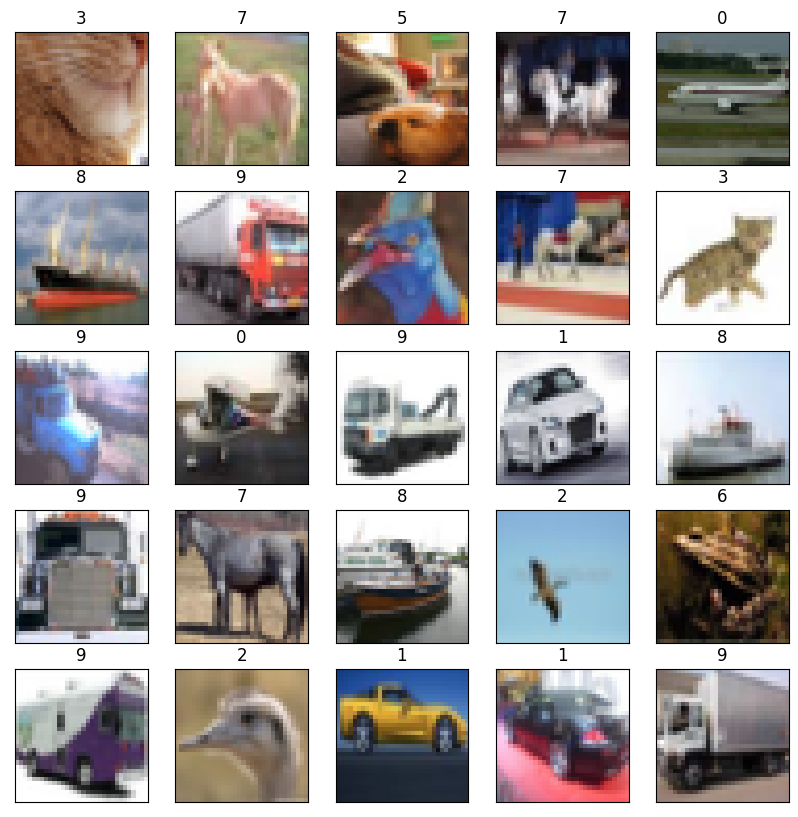

In [17]:
# Plot grid with first 25 training images with their corresponding label
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(y_train[i])
plt.show()

## Let's build and compare models

### VGG16 - Configuration "C"

In [22]:
model_name = 'vggnet-c'
batch_size = 512
epochs = 100

In [23]:
def get_vggnet(input_shape=(32, 32, 3)):
    X_input = layers.Input(input_shape)
    
    X = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same')(X_input)
    X = layers.Activation('relu')(X)
    X = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

    X = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    
    X = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    
    X = layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.Conv2D(filters=512, kernel_size=(1, 1), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    
    X = layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.Conv2D(filters=512, kernel_size=(1, 1), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    
    ### Prediction bloc
    X = layers.Flatten()(X)
    X = layers.Dense(4096)(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(.5)(X)
    
    X = layers.Dense(4096)(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(.5)(X)
    
    X = layers.Dense(1000)(X)
    X = layers.Activation('relu')(X)
    
    X = layers.Dense(no_classes)(X)
    X_output = layers.Activation('softmax')(X)
    return Model(inputs=[X_input], outputs=[X_output], name=model_name)

In [24]:
img_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
img_shape

(32, 32, 3)

In [25]:
# Define model, for a fully-connected network the input must be properly adapted
model = get_vggnet(img_shape)
model.summary()

Model: "vggnet-c"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_59 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 activation_74 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_60 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 activation_75 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                          

In [26]:
# Set hyperparameters
loss_function=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(3e-4)
metric = tf.keras.metrics.SparseCategoricalCrossentropy(name='test_acc')
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=25),
    TqdmCallback(verbose=0)
]

# Initialize trainer
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Train model
start_time = time.time()
results = model.fit(
    x_train, y_train,
    batch_size, epochs, 
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=0 # Supress fitting information
)

predictions = model.predict(x_test)
metric(y_test, predictions)
print(f'Execution time: {round(time.time() - start_time, 2)}s - Test accuracy: {metric.result()*10.:.2f}%')

0epoch [00:00, ?epoch/s]

2023-01-31 18:43:29.251366: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2023-01-31 18:43:29.928864: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-31 18:43:29.928889: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-31 18:43:30.003542: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

313/313 [==============================] - 1s 3ms/step
Execution time: 551.03s - Test accuracy: 18.04%


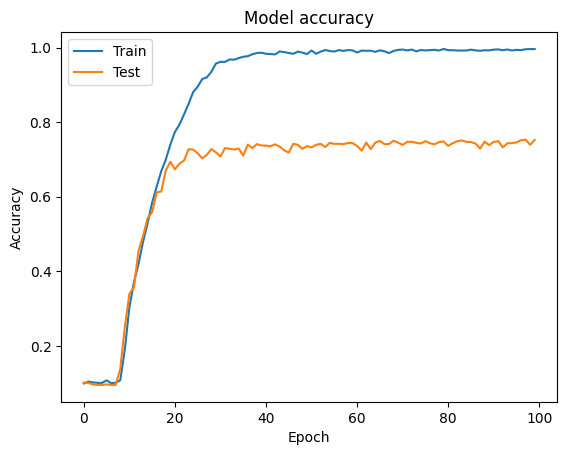

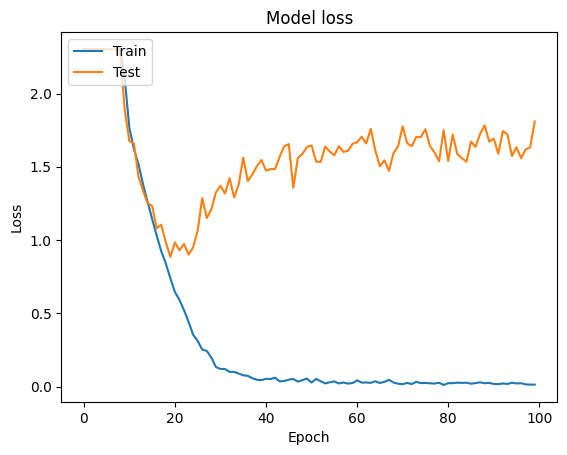

In [27]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [28]:
flat_preds= np.argmax(predictions, axis=1)
flat_preds.shape

(10000,)

In [29]:
confusion = confusion_matrix(y_test, flat_preds)
confusion

array([[784,   9,  45,  19,  15,  12,  10,  10,  57,  39],
       [ 12, 848,   1,  10,   2,   2,   8,   1,  35,  81],
       [ 53,   2, 549, 101, 109,  65,  75,  24,  12,  10],
       [ 15,   3,  34, 622,  61, 146,  60,  34,   9,  16],
       [  7,   1,  44,  62, 751,  25,  61,  42,   4,   3],
       [  7,   2,  26, 221,  39, 636,  20,  39,   2,   8],
       [  1,   3,  18,  83,  32,   9, 840,   5,   2,   7],
       [ 17,   1,  18,  45,  62,  65,   5, 766,   0,  21],
       [ 64,  15,   6,  25,   4,   2,  11,   2, 851,  20],
       [ 27,  49,   5,  27,   5,   1,   8,   4,  21, 853]])

Accuracy on unseen data: 18.04%


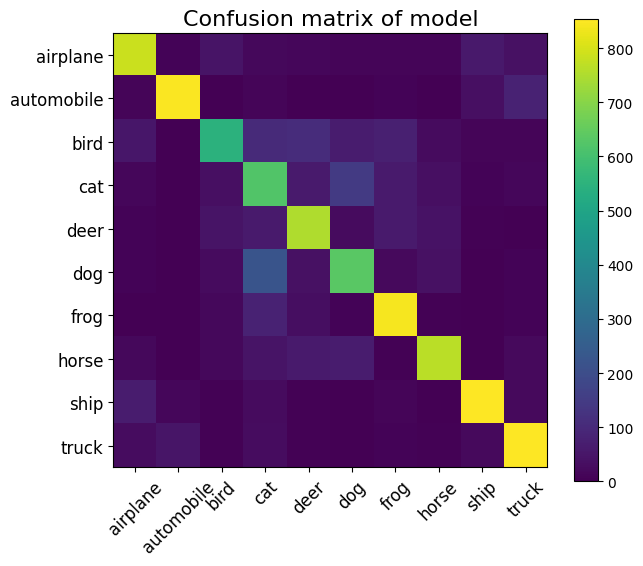

In [30]:
print(f'Accuracy on unseen data: {metric.result()*10.:.2f}%')

plt.figure(figsize=(7, 6))
plt.title(f'Confusion matrix of model', fontsize=16)
plt.imshow(confusion)
plt.xticks(np.arange(10), classe_names, rotation=45, fontsize=12)
plt.yticks(np.arange(10), classe_names, fontsize=12)
plt.colorbar()
plt.show()

In [31]:
model_file = f'{model_name}.h5'
print(f'Saving model to the current directory under {model_file} file')
model.save(f'{model_file}')

Saving model to the current directory under vggnet-c.h5 file


### VGG16 - Configuration "D"

In [18]:
model_name = 'vggnet-d'
batch_size = 512
epochs = 100

In [19]:
def get_vggnet(input_shape=(32, 32, 3)):
    X_input = layers.Input(input_shape)
    
    X = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same')(X_input)
    X = layers.Activation('relu')(X)
    X = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

    X = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    
    X = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    
    X = layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    
    X = layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)
    
    ### Prediction bloc
    X = layers.Flatten()(X)
    X = layers.Dense(4096)(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(.5)(X)
    
    X = layers.Dense(4096)(X)
    X = layers.Activation('relu')(X)
    X = layers.Dropout(.5)(X)
    
    X = layers.Dense(1000)(X)
    X = layers.Activation('relu')(X)
    
    X = layers.Dense(no_classes)(X)
    X_output = layers.Activation('softmax')(X)
    return Model(inputs=[X_input], outputs=[X_output], name=model_name)

In [20]:
img_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
img_shape

(32, 32, 3)

In [21]:
# Define model, for a fully-connected network the input must be properly adapted
model = get_vggnet(img_shape)
model.summary()

Model: "vggnet-d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                          

2023-01-31 20:34:41.029861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 20:34:41.030052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 20:34:41.030185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 20:34:41.030457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 20:34:41.030599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [22]:
# Set hyperparameters
loss_function=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(3e-4)
metric = tf.keras.metrics.SparseCategoricalCrossentropy(name='test_acc')
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=25),
    TqdmCallback(verbose=0)
]

# Initialize trainer
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Train model
start_time = time.time()
results = model.fit(
    x_train, y_train,
    batch_size, epochs, 
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=0 # Supress fitting information
)

predictions = model.predict(x_test)
metric(y_test, predictions)
print(f'Execution time: {round(time.time() - start_time, 2)}s - Test accuracy: {metric.result()*10.:.2f}%')

0epoch [00:00, ?epoch/s]

2023-01-31 20:34:43.442645: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


313/313 [==============================] - 1s 4ms/step
Execution time: 633.84s - Test accuracy: 15.66%


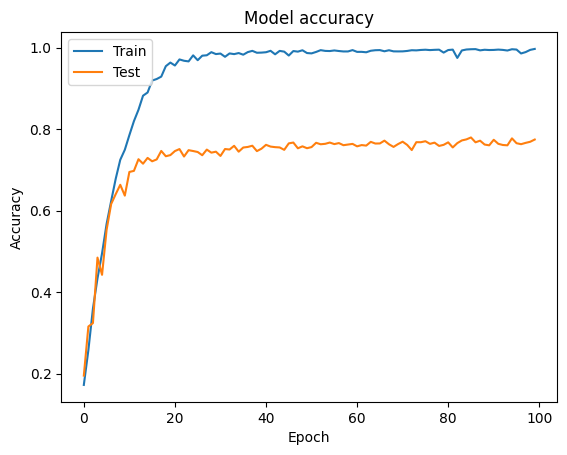

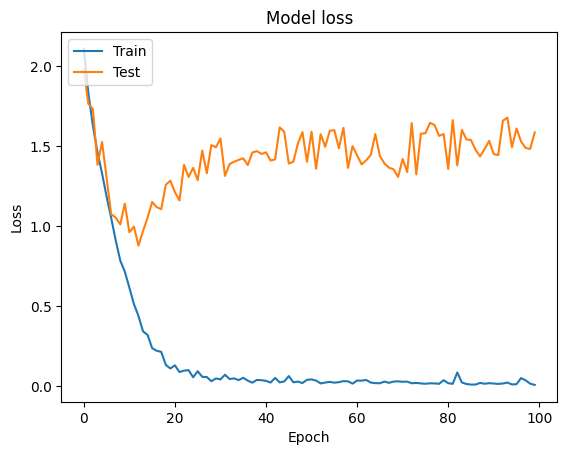

In [23]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
flat_preds= np.argmax(predictions, axis=1)
flat_preds.shape

(10000,)

In [25]:
confusion = confusion_matrix(y_test, flat_preds)
confusion

array([[841,   8,  47,   8,  12,   4,   8,   2,  39,  31],
       [ 11, 895,   0,   7,   3,   6,   5,   2,  12,  59],
       [ 79,   1, 668,  47,  68,  58,  49,   9,  11,  10],
       [ 28,   1,  76, 526,  55, 189,  62,  25,  13,  25],
       [ 24,   5,  68,  35, 756,  32,  32,  36,   8,   4],
       [  8,   4,  54, 129,  46, 700,  18,  29,   3,   9],
       [  5,   3,  42,  45,  31,  20, 838,   4,   8,   4],
       [ 26,   1,  24,  34,  48,  69,   2, 783,   1,  12],
       [ 60,  26,  10,   5,   3,   2,   4,   2, 872,  16],
       [ 28,  77,   4,  13,   1,  10,   4,   4,  15, 844]])

Accuracy on unseen data: 15.66%


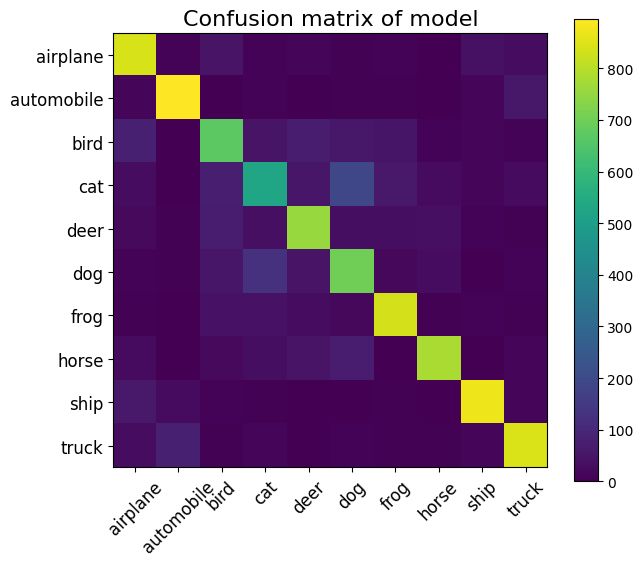

In [26]:
print(f'Accuracy on unseen data: {metric.result()*10.:.2f}%')

plt.figure(figsize=(7, 6))
plt.title(f'Confusion matrix of model', fontsize=16)
plt.imshow(confusion)
plt.xticks(np.arange(10), classe_names, rotation=45, fontsize=12)
plt.yticks(np.arange(10), classe_names, fontsize=12)
plt.colorbar()
plt.show()

In [27]:
model_file = f'{model_name}.h5'
print(f'Saving model to the current directory under {model_file} file')
model.save(f'{model_file}')

Saving model to the current directory under vggnet-d.h5 file
